In [1]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
import os
from glob import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
races = dict()

for path in glob('../data/processed/*'):
    print(path)
    filename = os.path.basename(path)
    races[filename[0].upper()] = pd.read_csv(path, index_col=0)

races.keys()

../data/processed/terran_1984_mar-05-2021_174444.csv
../data/processed/protoss_2308_mar-05-2021_174442.csv
../data/processed/zerg_2482_mar-05-2021_174446.csv


dict_keys(['T', 'P', 'Z'])

In [7]:
protoss_df = races['P'].copy()

match_ids = protoss_df.groupby(protoss_df['match_id']).tail(1)

In [8]:
match_ids.head()

,match_id,map_name,region,game_length,race,enemy_race,ap30s,frame,second,player,workers_active_count,food_used,food_made,minerals_current,minerals_collection_rate,minerals_used_in_progress,minerals_used_current,minerals_used_active_forces,minerals_lost,vespene_current,vespene_collection_rate,vespene_used_in_progress,vespene_used_current,vespene_used_active_forces,vespene_lost,adept,archon,assimilator,carrier,colossus,cyberneticscore,darkshrine,darktemplar,disruptor,fleetbeacon,forge,gateway,hightemplar,immortal,interceptor,mothership,mothershipcore,nexus,observer,oracle,phoenix,photoncannon,probe,pylon,reactor,roboticsbay,roboticsfacility,sentry,shieldbattery,stalker,stargate,tempest,templararchive,twilightcouncil,voidray,warpgate,warpprism,zealot,win
20,0,World of Sleepers LE,us,437,P,T,0.0,9600,600,Player 2 - Harstem (Protoss),56,81.0,117.0,235,2491,775,7425,625,2150,48,358,250,875,525,725,0,0,4,0,1,1,0,0,0,0,1,0,0,0,0,0,0,3,3,0,0,1,56,9,0,1,1,0,1,3,0,0,0,1,0,5,0,2,False
39,1,Thunderbird LE,us,414,P,P,0.0,8640,540,Player 1 - Harstem (Protoss),37,61.0,86.0,698,1595,250,6075,1175,1100,132,268,150,950,700,150,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,37,7,0,0,1,1,5,3,1,0,0,0,3,3,0,0,True
58,2,Thunderbird LE,us,414,P,P,0.0,8640,540,Player 2 - Stats (Protoss),17,43.0,63.0,205,951,200,4325,1325,1900,36,67,0,550,300,500,6,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17,6,0,1,1,0,1,3,0,0,0,0,0,3,1,3,False
85,3,Triton LE,us,580,P,T,65.8,12480,780,Player 1 - Harstem (Protoss),60,127.0,134.0,785,1875,500,11275,3675,3050,702,694,0,2500,1950,450,1,0,6,0,3,1,0,0,0,0,1,0,0,0,0,0,0,3,3,0,0,1,60,14,0,1,1,3,1,16,0,0,1,1,0,6,1,2,False
125,4,Disco Bloodbath LE,us,857,P,Z,127.4,18720,1170,Player 1 - Harstem (Protoss),66,162.0,212.0,315,2127,450,16525,5475,9475,215,1007,200,4125,3225,2925,0,4,8,0,0,1,0,0,0,1,1,0,0,2,0,0,0,4,1,1,17,5,66,19,0,0,1,0,5,0,2,0,1,1,0,8,0,15,True


       game_length
count  2308.000000
mean    704.892548
std     345.414055
min       5.000000
25%     486.000000
50%     638.000000
75%     844.000000
max    3552.000000


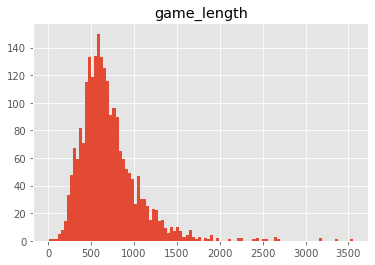

In [46]:
target = 'game_length'
minimum = match_ids.iloc[match_ids.loc[:,target].argmin(),:]
maximum = match_ids.iloc[match_ids.loc[:,target].argmax(),:]

print(match_ids.loc[:,[target]].describe())
match_ids.loc[:,[target]].hist(bins=100)
plt.show()

In [17]:
protoss_df.head()

,match_id,map_name,region,game_length,race,enemy_race,ap30s,frame,second,player,workers_active_count,food_used,food_made,minerals_current,minerals_collection_rate,minerals_used_in_progress,minerals_used_current,minerals_used_active_forces,minerals_lost,vespene_current,vespene_collection_rate,vespene_used_in_progress,vespene_used_current,vespene_used_active_forces,vespene_lost,adept,archon,assimilator,carrier,colossus,cyberneticscore,darkshrine,darktemplar,disruptor,fleetbeacon,forge,gateway,hightemplar,immortal,interceptor,mothership,mothershipcore,nexus,observer,oracle,phoenix,photoncannon,probe,pylon,reactor,roboticsbay,roboticsfacility,sentry,shieldbattery,stalker,stargate,tempest,templararchive,twilightcouncil,voidray,warpgate,warpprism,zealot,win
0,0,World of Sleepers LE,us,437,P,T,0.0,1,0,Player 2 - Harstem (Protoss),12,12.0,15.0,50,0,0,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,0,World of Sleepers LE,us,437,P,T,155.4,480,30,Player 2 - Harstem (Protoss),13,14.0,15.0,50,727,150,1050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,0,World of Sleepers LE,us,437,P,T,183.4,960,60,Player 2 - Harstem (Protoss),15,16.0,23.0,115,867,125,1250,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,0,World of Sleepers LE,us,437,P,T,148.4,1440,90,Player 2 - Harstem (Protoss),18,19.0,23.0,135,951,200,1475,0,0,12,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
4,0,World of Sleepers LE,us,437,P,T,152.6,1920,120,Player 2 - Harstem (Protoss),19,20.0,23.0,65,895,600,1525,0,0,56,111,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,19,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False


In [47]:
indexes_head = protoss_df.groupby(protoss_df['match_id']).head(1)
indexes_tail = protoss_df.groupby(protoss_df['match_id']).tail(1)

In [20]:
indexes.loc[:,['match_length']].hist(bins=40)

NameError: name 'indexes' is not defined

In [20]:
second_game_indexes = protoss_df[protoss_df.match_id == minimum.match_id].index
start, end = second_game_indexes[0], second_game_indexes[-1]

print(start, end)
a = protoss_df.iloc[:start,:]
b = protoss_df.iloc[start:end,:]

21 39


In [27]:
print(len(a))
a

21


,match_id,map_name,region,game_length,race,enemy_race,ap30s,frame,second,player,workers_active_count,food_used,food_made,minerals_current,minerals_collection_rate,minerals_used_in_progress,minerals_used_current,minerals_used_active_forces,minerals_lost,vespene_current,vespene_collection_rate,vespene_used_in_progress,vespene_used_current,vespene_used_active_forces,vespene_lost,adept,archon,assimilator,carrier,colossus,cyberneticscore,darkshrine,darktemplar,disruptor,fleetbeacon,forge,gateway,hightemplar,immortal,interceptor,mothership,mothershipcore,nexus,observer,oracle,phoenix,photoncannon,probe,pylon,reactor,roboticsbay,roboticsfacility,sentry,shieldbattery,stalker,stargate,tempest,templararchive,twilightcouncil,voidray,warpgate,warpprism,zealot,win
0,0,World of Sleepers LE,us,437,P,T,0.0,1,0,Player 2 - Harstem (Protoss),12,12.0,15.0,50,0,0,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,0,World of Sleepers LE,us,437,P,T,155.4,480,30,Player 2 - Harstem (Protoss),13,14.0,15.0,50,727,150,1050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,0,World of Sleepers LE,us,437,P,T,183.4,960,60,Player 2 - Harstem (Protoss),15,16.0,23.0,115,867,125,1250,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,0,World of Sleepers LE,us,437,P,T,148.4,1440,90,Player 2 - Harstem (Protoss),18,19.0,23.0,135,951,200,1475,0,0,12,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
4,0,World of Sleepers LE,us,437,P,T,152.6,1920,120,Player 2 - Harstem (Protoss),19,20.0,23.0,65,895,600,1525,0,0,56,111,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,19,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
5,0,World of Sleepers LE,us,437,P,T,138.6,2400,150,Player 2 - Harstem (Protoss),21,22.0,23.0,75,951,675,1775,0,0,112,179,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,21,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
6,0,World of Sleepers LE,us,437,P,T,131.6,2880,180,Player 2 - Harstem (Protoss),22,23.0,31.0,160,979,600,2000,0,0,184,246,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,22,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
7,0,World of Sleepers LE,us,437,P,T,126.0,3360,210,Player 2 - Harstem (Protoss),24,27.0,31.0,75,979,700,2250,0,0,75,313,125,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,24,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,False
8,0,World of Sleepers LE,us,437,P,T,126.0,3840,240,Player 2 - Harstem (Protoss),29,34.0,46.0,185,1063,175,3150,100,0,183,313,50,125,25,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,29,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,False
9,0,World of Sleepers LE,us,437,P,T,116.2,4320,270,Player 2 - Harstem (Protoss),31,37.0,46.0,90,1231,250,3375,225,0,49,313,100,175,75,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,31,2,0,0,1,0,0,1,0,0,0,1,0,1,0,0,False


In [26]:
print(len(b))
b

18


,match_id,map_name,region,game_length,race,enemy_race,ap30s,frame,second,player,workers_active_count,food_used,food_made,minerals_current,minerals_collection_rate,minerals_used_in_progress,minerals_used_current,minerals_used_active_forces,minerals_lost,vespene_current,vespene_collection_rate,vespene_used_in_progress,vespene_used_current,vespene_used_active_forces,vespene_lost,adept,archon,assimilator,carrier,colossus,cyberneticscore,darkshrine,darktemplar,disruptor,fleetbeacon,forge,gateway,hightemplar,immortal,interceptor,mothership,mothershipcore,nexus,observer,oracle,phoenix,photoncannon,probe,pylon,reactor,roboticsbay,roboticsfacility,sentry,shieldbattery,stalker,stargate,tempest,templararchive,twilightcouncil,voidray,warpgate,warpprism,zealot,win
21,1,Thunderbird LE,us,414,P,P,0.0,1,0,Player 1 - Harstem (Protoss),12,12.0,15.0,50,0,0,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
22,1,Thunderbird LE,us,414,P,P,179.2,480,30,Player 1 - Harstem (Protoss),13,14.0,15.0,45,699,150,1050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
23,1,Thunderbird LE,us,414,P,P,183.4,960,60,Player 1 - Harstem (Protoss),15,16.0,23.0,100,839,125,1250,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
24,1,Thunderbird LE,us,414,P,P,151.2,1440,90,Player 1 - Harstem (Protoss),18,19.0,23.0,105,923,200,1475,0,0,8,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,True
25,1,Thunderbird LE,us,414,P,P,135.8,1920,120,Player 1 - Harstem (Protoss),19,20.0,23.0,40,923,600,1525,0,0,48,134,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,19,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,True
26,1,Thunderbird LE,us,414,P,P,147.0,2400,150,Player 1 - Harstem (Protoss),20,21.0,23.0,45,895,675,1725,0,0,104,179,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,20,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,True
27,1,Thunderbird LE,us,414,P,P,148.4,2880,180,Player 1 - Harstem (Protoss),22,23.0,31.0,240,979,600,2000,0,0,164,201,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,22,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,True
28,1,Thunderbird LE,us,414,P,P,123.2,3360,210,Player 1 - Harstem (Protoss),24,27.0,31.0,100,979,725,2250,0,0,22,313,200,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,24,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,True
29,1,Thunderbird LE,us,414,P,P,126.0,3840,240,Player 1 - Harstem (Protoss),26,32.0,46.0,25,1035,475,2875,125,0,88,313,200,50,50,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,26,2,0,0,0,0,1,1,1,0,0,0,0,1,0,0,True
30,1,Thunderbird LE,us,414,P,P,138.6,4320,270,Player 1 - Harstem (Protoss),28,35.0,46.0,160,1119,400,3250,250,50,54,335,150,250,100,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,28,2,0,0,0,0,1,2,1,0,0,0,0,1,0,0,True


In [23]:
len(a), len(b)

(21, 18)

263.1999999999997
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 4), (5, 5), (6, 6), (7, 7), (8, 7), (9, 7), (10, 7), (11, 8), (12, 8), (13, 9), (14, 10), (15, 11), (16, 11), (17, 11), (18, 12), (18, 13), (18, 14), (19, 15), (19, 16), (20, 17)]


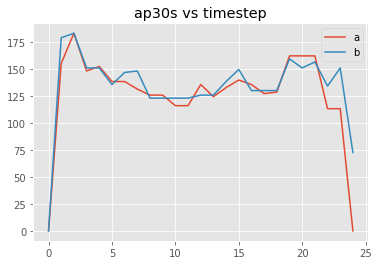

In [63]:
from fastdtw import fastdtw

ay = a.loc[:,'ap30s'].to_numpy()
by = b.loc[:,'ap30s'].to_numpy()

distance, path = fastdtw(ay, by)

print(distance)
print(path)

aa, bb = list(zip(*path))
aa = list(aa)
bb = list(bb)

plt.title('ap30s vs timestep')
plt.plot(range(len(path)), ay[aa], label='a')
plt.plot(range(len(path)), by[bb], label='b')
plt.legend()
plt.show()

100.0
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (8, 9), (9, 10), (10, 11), (11, 12), (11, 13), (12, 14), (13, 15), (14, 15), (15, 15), (16, 16), (17, 16), (18, 16), (19, 16), (20, 17)]


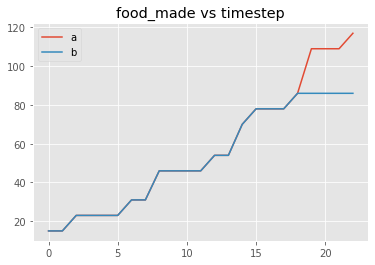

In [43]:
from fastdtw import fastdtw

ay = a.loc[:,'food_made'].to_numpy()
by = b.loc[:,'food_made'].to_numpy()

distance, path = fastdtw(ay, by)

print(distance)
print(path)

aa, bb = zip(*path)
aa = list(aa)
bb = list(bb)

plt.title('food_made vs timestep')
plt.plot(range(len(aa)), ay[aa], label='a')
plt.plot(range(len(aa)), by[bb], label='b')
plt.legend()
plt.show()